# Setup We fix a random seed so that any random examples (if used) behave the same for everyone.

In [1]:
from __future__ import annotations  # Lets us use type hints more cleanly (safe to ignore for now)

from dataclasses import dataclass   # Simple way to define small data containers (used later)
from typing import Callable, List, Tuple  # Type hints for clarity (functions, lists, and pairs)

import numpy as np                  # Numerical computing (arrays, maths, random numbers)
import matplotlib.pyplot as plt     # Plotting (graphs and visualisations)

SEED = 42                           # Constant to make randomness reproducible
rng = np.random.default_rng(SEED)   # Controlled random number generator for this notebook

print("Setup complete, seed =", SEED)  # Quick confirmation that the environment is ready

Setup complete, seed = 42


# Plot the landscape so we can see the peaks and valleys visually

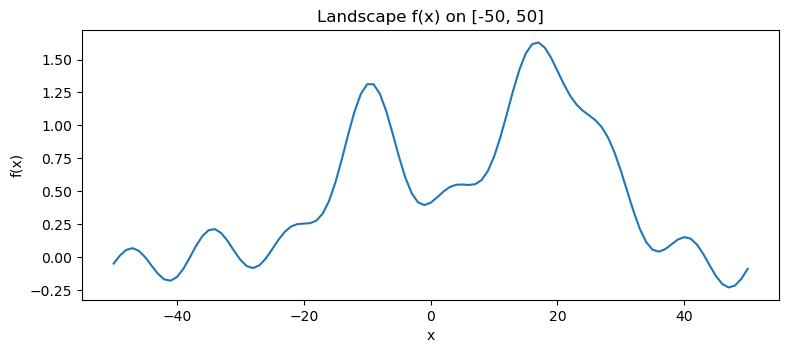

In [2]:
# Define a bumpy landscape (multi-modal) and plot it
# "Multi-modal" means the function has multiple peaks (local maxima),
# which is exactly where hill climbing can get stuck.

def f(x: int) -> float:
    # f(x) is built by combining a few simple patterns:
    # - Two Gaussian "humps" (smooth peaks) centred at x=18 and x=-10
    # - Small sinusoidal ripples (sin/cos) to add extra bumps and plateaus
    #
    # This creates several local maxima, not just one global peak.
    return (
        1.6 * np.exp(-((x - 18) ** 2) / 120)   # Main peak near x = 18 (wider, higher)
        + 1.2 * np.exp(-((x + 10) ** 2) / 60)  # Secondary peak near x = -10 (narrower)
        + 0.15 * np.sin(x / 2)                 # Small oscillations (adds local bumps)
        + 0.08 * np.cos(x / 5)                 # Even smaller oscillations (fine detail)
    )

# Create the integer search space x ∈ {-50, -49, ..., 50}
X = np.arange(-50, 51)

# Evaluate the objective at every x (so we can plot the entire landscape)
Y = np.array([f(int(x)) for x in X])

# Plot the landscape so we can see the peaks and valleys visually
plt.figure(figsize=(9, 3.5))     # Wider figure makes the 1D shape easier to read
plt.plot(X, Y)                   # Draw f(x) for all x in the range
plt.title("Landscape f(x) on [-50, 50]")
plt.xlabel("x")                  # Decision variable
plt.ylabel("f(x)")               # Objective value (what hill climbing tries to maximise)
plt.show()


# Choose a random starting point so different runs can end at different local maxima.

Start x = -41 | f(x) = -0.1767
Final x = -34 | f(x) = 0.2138 | steps = 7


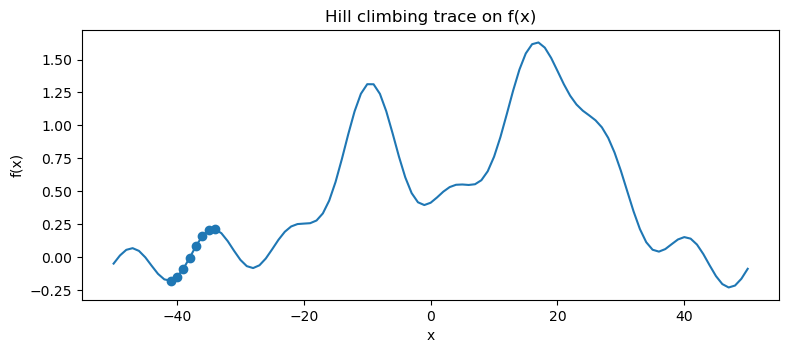

In [3]:
def neighbours_1d(x: int, lo: int = -50, hi: int = 50) -> List[int]:
    # Neighbourhood definition for 1D integer search:
    # from x, you can move one step left (x-1) or one step right (x+1),
    # as long as you stay within the bounds [lo, hi].
    nbs = []
    if x - 1 >= lo:              # Left move is valid
        nbs.append(x - 1)
    if x + 1 <= hi:              # Right move is valid
        nbs.append(x + 1)
    return nbs


def hill_climb_best_improvement(
    start: int,
    objective: Callable[[int], float],
    neighbours: Callable[[int], List[int]],
    max_steps: int = 1000,
) -> Tuple[int, float, List[int]]:
    """Best-improvement hill climbing (steepest ascent).

    At each iteration:
      1) generate neighbours of the current state,
      2) evaluate them using the objective function,
      3) move to the best neighbour if (and only if) it improves the score.

    Returns:
      (final_state, final_score, trace)
      - final_state: where we stopped (a local maximum w.r.t. the neighbourhood)
      - final_score: objective value at that state
      - trace: the sequence of visited states (useful for plotting the path)
    """
    current = start
    current_score = objective(current)
    trace = [current]            # Keep the full path so we can visualise the search

    for _ in range(max_steps):
        cand = neighbours(current)               # Candidate next states (1-step moves)
        scores = [objective(s) for s in cand]    # Evaluate objective for each candidate

        # Pick the neighbour with the highest score (steepest ascent)
        best_i = int(np.argmax(scores))
        best_state = cand[best_i]
        best_score = scores[best_i]

        # Stopping rule:
        # if the best neighbour is not strictly better, we are at a local maximum.
        if best_score <= current_score:
            break

        # Otherwise move "uphill" and continue
        current, current_score = best_state, best_score
        trace.append(current)

    return current, float(current_score), trace

# Choose a random starting point so different runs can end at different local maxima.
# We use rng (seeded earlier) so the run is reproducible for everyone.
start = int(rng.integers(-50, 51))

# Run hill climbing on our landscape f(x)
best_x, best_fx, trace = hill_climb_best_improvement(start, f, neighbours_1d)

# Report the start and the final solution
print("Start x =", start, "| f(x) =", round(f(start), 4))
print("Final x =", best_x, "| f(x) =", round(best_fx, 4), "| steps =", len(trace) - 1)

# Visualise the hill-climbing path on top of the landscape:
# the dots show the visited x values in the order they were chosen.
plt.figure(figsize=(9, 3.5))
plt.plot(X, Y)                                  # The full landscape
plt.scatter(trace, [f(t) for t in trace])       # The hill-climbing trace (visited points)
plt.title("Hill climbing trace on f(x)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()


#  Exercise 1 solution: Hill climbing on a 1D landscape

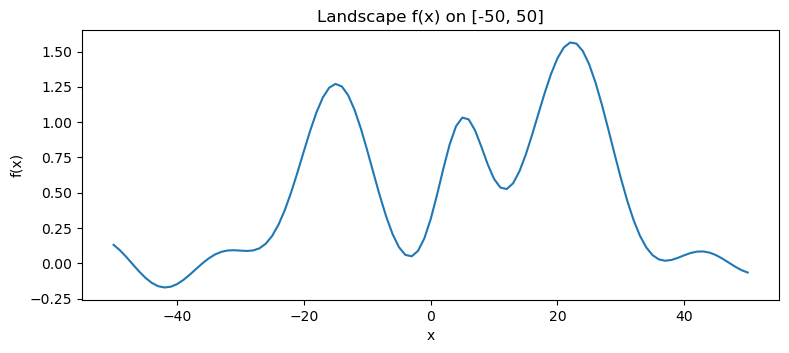

Single-start hill climb
Start x = 28 | f(x) = 0.9526
Final x = 22 | f(x) = 1.5647 | steps = 6


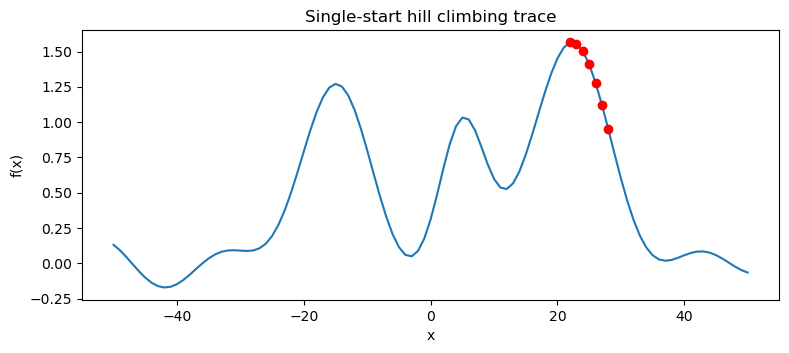


Random-restart hill climbing (k=20), repeated 5 times
Run 1: best x = 22, best f(x) = 1.5647
Run 2: best x = 22, best f(x) = 1.5647
Run 3: best x = 22, best f(x) = 1.5647
Run 4: best x = 22, best f(x) = 1.5647
Run 5: best x = 22, best f(x) = 1.5647

Comparison
Best f(x) from ONE single-start hill climb = 1.5647
Best f(x) from random-restart (k=20), best over 5 repeats = 1.5647


In [4]:


from typing import Callable, List, Tuple

def f(x: int) -> float:
    return (
        1.4 * np.exp(-((x - 22) ** 2) / 90)
        + 1.1 * np.exp(-((x + 15) ** 2) / 70)
        + 0.9 * np.exp(-((x - 5) ** 2) / 25)
        + 0.12 * np.sin(x / 3)
        - 0.07 * np.cos(x / 6)
    )

def neighbours_1d(x: int, lo: int = -50, hi: int = 50) -> List[int]:
    nbs = []
    if x - 1 >= lo:
        nbs.append(x - 1)
    if x + 1 <= hi:
        nbs.append(x + 1)
    return nbs

def hill_climb_best_improvement(
    start: int,
    objective: Callable[[int], float],
    neighbours: Callable[[int], List[int]],
    max_steps: int = 1000,
) -> Tuple[int, float, List[int]]:
    current = start
    current_score = objective(current)
    trace = [current]
    for _ in range(max_steps):
        cand = neighbours(current)
        scores = [objective(s) for s in cand]
        best_i = int(np.argmax(scores))
        best_state = cand[best_i]
        best_score = scores[best_i]
        if best_score <= current_score:
            break
        current, current_score = best_state, best_score
        trace.append(current)
    return current, float(current_score), trace

# --- Step 1 & 2: Plot the landscape ---
X = np.arange(-50, 51)
Y = np.array([f(int(x)) for x in X])

plt.figure(figsize=(9, 3.5))
plt.plot(X, Y)
plt.title("Landscape f(x) on [-50, 50]")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()


# --- Step 4: Single-start hill climb ---
start = int(rng.integers(-50, 51))
best_x_single, best_fx_single, trace_single = hill_climb_best_improvement(start, f, neighbours_1d)

print("Single-start hill climb")
print("Start x =", start, "| f(x) =", round(f(start), 4))
print("Final x =", best_x_single, "| f(x) =", round(best_fx_single, 4), "| steps =", len(trace_single) - 1)

plt.figure(figsize=(9, 3.5))
plt.plot(X, Y)
plt.scatter(trace_single, [f(t) for t in trace_single], color='red', zorder=5)
plt.title("Single-start hill climbing trace")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

def random_restart_hill_climb(
    k: int,
    objective: Callable[[int], float],
    neighbours: Callable[[int], List[int]],
    hill_climb_fn: Callable,
    lo: int = -50,
    hi: int = 50,
) -> Tuple[int, float]:
    best_x = None
    best_fx = -float("inf")
    for _ in range(k):
        start = int(rng.integers(lo, hi + 1))
        x_final, fx_final, _trace = hill_climb_fn(start, objective, neighbours)
        if fx_final > best_fx:
            best_x, best_fx = x_final, fx_final
    return int(best_x), float(best_fx)

# --- Step 6: Repeat random-restart 5 times with k=20 ---
print("\nRandom-restart hill climbing (k=20), repeated 5 times")
restart_results = []
for i in range(1, 6):
    bx, bfx = random_restart_hill_climb(
        k=20, objective=f, neighbours=neighbours_1d,
        hill_climb_fn=hill_climb_best_improvement
    )
    restart_results.append((bx, bfx))
    print(f"Run {i}: best x = {bx}, best f(x) = {bfx:.4f}")

# --- Step 7: Final comparison ---
best_fx_rr_overall = max(r[1] for r in restart_results)
print("\nComparison")
print("Best f(x) from ONE single-start hill climb =", round(best_fx_single, 4))
print("Best f(x) from random-restart (k=20), best over 5 repeats =", round(best_fx_rr_overall, 4))


# Knapsack instance

In [5]:
# Knapsack instance
# We define a small 0/1 knapsack problem:
# - Each item can be either selected (1) or not selected (0), you cannot take fractions.
# - Each item has a weight (cost) and a value (benefit).
# - The goal is to maximise total value while keeping total weight ≤ CAPACITY.

@dataclass(frozen=True)
class Item:
    # A simple immutable data structure for one item in the knapsack
    name: str          # Identifier (A, B, C, ...)
    weight: int        # How much capacity this item consumes
    value: int         # How much benefit this item provides

# A toy dataset with different trade-offs:
# some items are light but low value, others are heavy but high value.
# The optimiser must find a good combination that fits within the capacity.
items = [
    Item("A", 4, 12),  # Medium weight, good value
    Item("B", 2, 6),   # Light, decent value
    Item("C", 2, 7),   # Light, slightly better than B
    Item("D", 6, 18),  # Heavy, high value
    Item("E", 5, 14),  # Medium-heavy, good value
    Item("F", 3, 8),   # Medium, moderate value
    Item("G", 7, 20),  # Very heavy, very high value (tempting but expensive)
    Item("H", 1, 3),   # Very light, low value (useful for filling small gaps)
    Item("I", 4, 10),  # Medium weight, moderate value
    Item("J", 3, 9),   # Medium, good value
    Item("K", 5, 13),  # Medium-heavy, moderate value
    Item("L", 2, 5),   # Light, modest value
]

CAPACITY = 15  # Maximum total weight allowed in the knapsack

print("Items:", len(items), "| capacity:", CAPACITY)  # Quick sanity check

Items: 12 | capacity: 15


In [ ]:
# Objective and helpers
# We represent a knapsack solution as a 0/1 "bitstring" of length n_items:
# - bitstring[i] = 1 means we TAKE item i
# - bitstring[i] = 0 means we DO NOT take item i
#
# Hill climbing (or any local search) needs:
# 1) a way to evaluate a solution (objective / score)
# 2) a way to generate neighbouring solutions (small local moves)

def unpack(bitstring: np.ndarray) -> Tuple[int, int, List[str]]:
    """Return (total_weight, total_value, item_names).

    This converts the bitstring into interpretable quantities:
    - total_weight: how much capacity we used
    - total_value: how much value we gained
    - item_names: which items were selected
    """
    w = 0
    v = 0
    names = []
    for take, it in zip(bitstring, items):
        if int(take) == 1:       # Item selected
            w += it.weight
            v += it.value
            names.append(it.name)
    return w, v, names


def knapsack_score(bitstring: np.ndarray, penalty: float = 50.0) -> float:
    """Higher is better. Overweight solutions are penalised.

    We use a penalty approach so the optimiser always has a single number to maximise.

    - If the solution is feasible (weight <= CAPACITY), score = total_value.
    - If the solution is overweight, we subtract a large penalty proportional to the excess:
        score = total_value - penalty * (excess_weight)

    The penalty needs to be "big enough" so that going overweight is usually not worth it.
    """
    w, v, _ = unpack(bitstring)
    if w <= CAPACITY:
        return float(v)          # Feasible: pure value
    return float(v - penalty * (w - CAPACITY))  # Overweight: value minus penalty


def neighbours_flip_one(bitstring: np.ndarray) -> List[np.ndarray]:
    """All neighbours by flipping a single bit.

    A single-bit flip is the simplest local move for 0/1 knapsack:
    - 0 -> 1 means "add this item"
    - 1 -> 0 means "remove this item"

    This produces exactly n neighbours for a problem with n items.
    """
    nbs = []
    for i in range(len(bitstring)):
        nb = bitstring.copy()    # Copy so we do not modify the original solution
        nb[i] = 1 - nb[i]        # Flip the i-th decision bit (0<->1)
        nbs.append(nb)
    return nbs
